In [31]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.ma as ma
import pandas as pd
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd

# Rasterstats contains the zonalstatistics function 
# that you will use to extract raster values
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep

import zipfile

# Set consistent plotting style
sns.set_style("white")
sns.set(font_scale=1.5)

In [32]:
# Load & plot the data
ch4_path = os.path.join("data", "CH4_2019.tif")

with rio.open(ch4_path) as ch4_src:
    # Masked = True sets no data values to np.nan if they are in the metadata
    ch4_data = ch4_src.read(1, masked=True)
    ch4_meta = ch4_src.profile

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


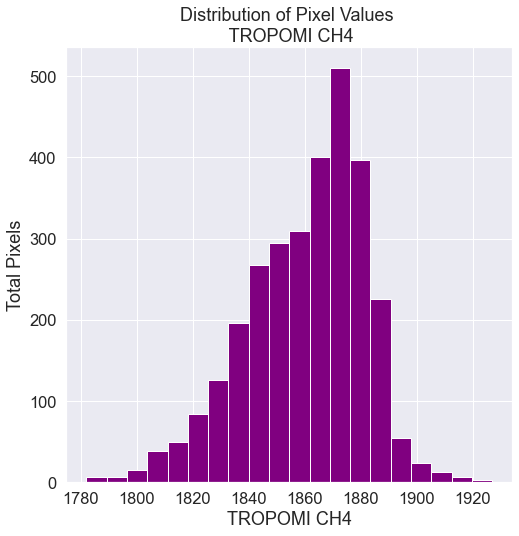

In [33]:
# Explore the data by plotting a histogram with earthpy
ax=ep.hist(ch4_data,
        figsize=(8,8),
        colors="purple",
        xlabel="TROPOMI CH4",
        ylabel="Total Pixels",
        title="Distribution of Pixel Values \n TROPOMI CH4")

# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                     style='plain')

In [63]:
def listdirs(path):
    return [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

['Vista_CA_Refineries',
 'Vista_CA_Composting_Sites',
 'Vista_CA_Landfills',
 'Vista_CA_Digesters',
 'Vista_CA_NG_Fueling_Stations',
 'Vista_CA_Feed_Lots',
 'Vista_CA_Processing_Plants',
 'Vista_CA_Power_Plants',
 'Vista_CA_Wastewater_Treatment_Plants',
 'Vista_CA_NG_Stations',
 'Vista_CA_Dairies',
 'Vista_CA_Oil_and_Gas_Field_Boundaries',
 'Vista_CA_Oil_and_Gas_Wells',
 'Vista_CA_Storage_Fields',
 'Vista_CA_Oil_and_Gas_Facilities']

In [72]:
for subdir in listdirs('data/NACP_Vista_CA_CH4_Inventory_1726/data'):
    points_gdf = gpd.read_file(path + '/' + subdir + '/' + subdir + '.shp')
    
    # Create 20m buffer
    poly_gdf = points_gdf.copy()
    poly_gdf["geometry"] =points_gdf.geometry.buffer(.1)
    
    # Extract zonal stats
    zonal_stats = rs.zonal_stats(poly_gdf,
                                       ch4_data,
                                       nodata=-999,
                                       affine=ch4_meta['transform'],
                                       geojson_out=True,
                                       copy_properties=True,
                                       stats="count min mean max median")

    # View object type
    type(zonal_stats)


    zonal_stats_df = gpd.GeoDataFrame.from_features(zonal_stats)
    
    zonal_stats_df.to_file('outdata/ch4_points/' + subdir +'.json', driver='GeoJSON')

<ipython-input-72-31bc92671d5c>:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  poly_gdf["geometry"] =points_gdf.geometry.buffer(.1)


In [67]:
# import points
# points_gdf = gpd.read_file('zip://data/NACP_Vista_CA_CH4_Inventory_1726/data/Vista_CA_Feed_Lots.zip')
points_gdf = gpd.read_file("data/NACP_Vista_CA_CH4_Inventory_1726/data/Vista_CA_Feed_Lots/Vista_CA_Feed_Lots.shp")


In [49]:
points_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [50]:
poly_gdf = points_gdf.copy()
poly_gdf["geometry"] =points_gdf.geometry.buffer(20)
poly_gdf.head()

<ipython-input-50-6343fec1026c>:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  poly_gdf["geometry"] =points_gdf.geometry.buffer(20)


,Latitude,Longitude,City,State,Source,Vista_ID,VistaIPCC,VistaName,VistaSType,VistaDate,geometry
0,37.519455,-120.749914,DENAIR,CA,RAFIQ,FDL000022,3A1 Enteric Fermentation,G & S Cattle Co of Turlock,Feed Lot,2019-11-10,"POLYGON ((-100.74991 37.51946, -100.84622 35.5..."
1,37.727375,-120.841383,OAKDALE,CA,RAFIQ,FDL000019,3A1 Enteric Fermentation,Farmers Livestock Market,Feed Lot,2019-11-10,"POLYGON ((-100.84138 37.72738, -100.93769 35.7..."
2,38.304731,-121.316172,GALT,CA,RAFIQ,FDL000007,3A1 Enteric Fermentation,Cattlemen's Livestock Market,Feed Lot,2019-11-10,"POLYGON ((-101.31617 38.30473, -101.41248 36.3..."
3,38.328705,-121.188084,HERALD,CA,RAFIQ,FDL000010,3A1 Enteric Fermentation,Clay Station Feed Lot,Feed Lot,2019-11-10,"POLYGON ((-101.18808 38.32871, -101.28439 36.3..."
4,39.698616,-122.199166,ORLAND,CA,RAFIQ,FDL000045,3A1 Enteric Fermentation,Orland Livestock Commission,Feed Lot,2019-11-10,"POLYGON ((-102.19917 39.69862, -102.29547 37.7..."


In [51]:
# Extract zonal stats
zonal_stats = rs.zonal_stats(poly_gdf,
                                   ch4_data,
                                   nodata=-999,
                                   affine=ch4_meta['transform'],
                                   geojson_out=True,
                                   copy_properties=True,
                                   stats="count min mean max median")

# View object type
type(zonal_stats)


zonal_stats_df = gpd.GeoDataFrame.from_features(zonal_stats)

In [46]:
zonal_stats_df.head()

,geometry,City,Latitude,Longitude,Source,State,VistaDate,VistaIPCC,VistaName,VistaSType,Vista_ID,min,max,mean,count,median
0,"POLYGON ((-100.74991 37.51946, -100.84622 35.5...",DENAIR,37.519455,-120.749914,RAFIQ,CA,2019-11-10,3A1 Enteric Fermentation,G & S Cattle Co of Turlock,Feed Lot,FDL000022,1782.061768,1926.985028,1860.481269,3029,1864.375544
1,"POLYGON ((-100.84138 37.72738, -100.93769 35.7...",OAKDALE,37.727375,-120.841383,RAFIQ,CA,2019-11-10,3A1 Enteric Fermentation,Farmers Livestock Market,Feed Lot,FDL000019,1782.061768,1926.985028,1860.481269,3029,1864.375544
2,"POLYGON ((-101.31617 38.30473, -101.41248 36.3...",GALT,38.304731,-121.316172,RAFIQ,CA,2019-11-10,3A1 Enteric Fermentation,Cattlemen's Livestock Market,Feed Lot,FDL000007,1782.061768,1926.985028,1860.481269,3029,1864.375544
3,"POLYGON ((-101.18808 38.32871, -101.28439 36.3...",HERALD,38.328705,-121.188084,RAFIQ,CA,2019-11-10,3A1 Enteric Fermentation,Clay Station Feed Lot,Feed Lot,FDL000010,1782.061768,1926.985028,1860.481269,3029,1864.375544
4,"POLYGON ((-102.19917 39.69862, -102.29547 37.7...",ORLAND,39.698616,-122.199166,RAFIQ,CA,2019-11-10,3A1 Enteric Fermentation,Orland Livestock Commission,Feed Lot,FDL000045,1782.061768,1926.985028,1860.481269,3029,1864.375544
